# Проектная работа
# Анализ поездок агрегатора  такси
_____
**Описание исследования.**
Определить периоды времени, когда возможно недостаточно водителей для удовлетворения спроса на поездки, и объемы недополученной из-за этого выручки, определить, сколько водителей нужно привлечь для повышения доходов.

Мы имеем данные о поездках в крупном городе, совершенных в период с 1 февраля по 31 марта 2015 года:
   - Датафрейм `taxi_data` предоставляет ценную информацию для анализа поездок такси, включая продолжительность, расстояние, оплату и географические координаты мест посадки и высадки. Его можно использовать для получения информации о моделях использования такси, распределении платы за проезд, популярных местах посадки/высадки и многом другом.
   - Датафрейм `estimated_coverage`, где находится рассчитанная на основании данных доля уникальных клиентов в этот час, которым был предложен вариант поездки по запросу (даже если они не воспользовались услугой).

_____
**Цель исследования.**

Изучить:
   - Периоды, в которые были совершены поездки
   - Количество машин, поездок
   - Стоимость тарифа, общую стоимость поездок, чаевые, заработок водителя
   - Коэффициент покрытия машинами и его связь с другими показателями
  
_____
**Задачи исследования.**

Изучить датасет с исходными данными. Выполнить предобработку данных, провести анализ данных датасета, чтобы впоследствии выявить взаимосвязь между временем работы водителей, количеством поездок, тарифа и доходов.

**Этапы проекта:**
> &nbsp;
> 1. Подготовить данные для анализа
> >  * Найти аномалии в данных, принять решение о их сохранении или отбрасывании
> 2. Рассчитать для каждого часа:
> >  * Количество машин на линии (только по данным начала поездок)
> >  * Количество поездок
> >  * Среднюю длительность поездки
> >  * Среднюю длинну поездки
> >  * Среднюю тарифную стоимость поездки
> >  * Иные показатели, включая показатели из расчёта на одного водителя, включая общую выручку и выручку водителя (исходя из того, что водитель получает 60% тарифа за поездку и все чаевые)
> 3. Определить периоды когда водители получают
> >  * выручку исходя из тарифа ниже среднего
> >  * меньше чаевых
> 4. Определить критические периоды дефицита предложения
> >  * рассчитать оптимальное число машин на линии для обеспечения нормального показателя покрытия
> 5. Визуализировать найденные в п.4 и важные рассчитанные ранее показатели с учётом недельных и суточных циклов
>
> 6. Определить периоды, в которые меры стимулирования предложения услуг такси нужны и будут наиболее эффективны
>
> 7. В рамках определённых в п.6 периодов оценить:
> >  * объём недополученной общей выручки из-за низкого предложения
> >  * дефицит количества машин на линии (сколько нужно вывести машин дополнительно, чтобы достичь нормального покрытия)
> 8. (опционально) Предложить меры стимулирования предложения и оцените их эффективность
>
> 9. Подготовить презентацию на 7-10 слайдов с основными результатами проекта.
> &nbsp;<br><br>

1. [**Открытие данных**](#start)

2. [**Предобработка данных**](#preprocessing)

3. [**Расчет необходимых показателей для каждого часа и дня недели**](#time)
- Выручка и чаевые ниже среднего
4. [**Критические периоды дефицита предложения и визуализации**](#analysis)
       
5. [**Выводы**](#end)
    
6. [**Презентация**](#presentation)

Импортируем модуль `pyarrow` и все необходимые библиотеки:

In [1]:
!pip install pyarrow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from plotly import graph_objects as go
import seaborn as sns
from numpy import median
from IPython.display import Image

### Открытие данных<a id="start"></a>

Откроем датафреймы и изучим информацию о них:

In [3]:
df = pd.read_feather('Taxi_data.ftr')
df_cover = pd.read_feather('Estimated_coverage.ftr')

Датафрейм `taxi_data`:

In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826887 entries, 0 to 1826886
Data columns (total 18 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip Start Timestamp        1826887 non-null  datetime64[ns]
 1   Trip End Timestamp          1826887 non-null  datetime64[ns]
 2   Trip Seconds                1826871 non-null  float64       
 3   Trip Miles                  1826883 non-null  float64       
 4   Pickup Community Area       1602394 non-null  float64       
 5   Dropoff Community Area      1568478 non-null  float64       
 6   Fare                        1826885 non-null  float64       
 7   Tips                        1826885 non-null  float64       
 8   Tolls                       1826885 non-null  float64       
 9   Extras                      1826885 non-null  float64       
 10  Trip Total                  1826885 non-null  float64       
 11  Payment Type            

`taxi_data` содержит следующие столбцы:

* Trip Start Timestamp: дата и время начала поездки
* Trip End Timestamp: дата и время окончания поездки
* Trip Seconds: продолжительность поездки в секундах
* Trip Miles: расстояние, пройденное во время поездки в милях
* Pickup Community Area: зона, где был подобран клиент
* Dropoff Community Area: зона, где был высажен клиент
* Fare: сумма тарифа, взимаемая за поездку в долларах
* Tips: сумма чаевых за поездку
* Tolls: сумма, уплачиваемая во время поездки (за платные дороги)
* Extras: Дополнительные сборы за поездку
* Trip Total: общая сумма оплаты за поездку
* Payment Type: Тип оплаты поездки
* Company: Компания такси, связанная с поездкой
* Pickup Centroid Latitude, Pickup Centroid Longitude, Dropoff Centroid Latitude, Dropoff Centroid Longitude: координаты центров кластеров посадки/высадки
* Taxi ID: Уникальный идентификатор такси


Датафрейм `estimated_coverage`:

In [5]:
df_cover.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413 entries, 0 to 1412
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Hour Trip Start     1413 non-null   datetime64[ns]
 1   Estimated coverage  1411 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.2 KB


`estimated_coverage` содержит следующие столбцы:

* Hour Trip Start: час начала поездки
* Estimated coverage: расчётная величина покрытия машинами

Отобразим первые строки `Taxi data`, записанные в переменную `df`:

In [6]:
df.head(4)

Trip Start Timestamp  Trip End Timestamp  Trip Seconds  Trip Miles  \
0  2015-02-06 06:45:00 2015-02-06 07:00:00         540.0         2.8   
1  2015-02-13 20:30:00 2015-02-13 20:45:00         600.0         2.0   
2  2015-03-11 23:30:00 2015-03-11 23:45:00         540.0         0.1   
3  2015-03-13 22:15:00 2015-03-13 22:15:00         360.0         1.7   

   Pickup Community Area  Dropoff Community Area  Fare  Tips  Tolls  Extras  \
0                   21.0                    15.0  8.85   0.0    0.0     0.0   
1                    8.0                    28.0  8.25   1.0    0.0     0.0   
2                   28.0                     8.0  7.65   0.0    0.0     0.0   
3                   33.0                    32.0  6.65   0.0    0.0     1.0   

   Trip Total Payment Type                    Company  \
0        8.85    No Charge        Top Cab Affiliation   
1        9.25  Credit Card      KOAM Taxi Association   
2        7.65         Cash  Taxi Affiliation Services   
3        7.65  Credit Card    Choice Taxi Association   

   Pickup Centroid Latitude  Pickup Centroid Longitude  \
0                 41.938666                 -87.711211   
1                 41.890922                 -87.618868   
2                 41.879255                 -87.642649   
3                 41.849247                 -87.624135   

   Dropoff Centroid Latitude  Dropoff Centroid Longitude  Taxi ID  
0                  41.954028                  -87.763399      250  
1                  41.879067                  -87.657005     1915  
2                  41.892508                  -87.626215      110  
3                  41.871016                  -87.631407     1802

Отобразим первые строки `estimated coverage`, записанные в переменную `df_cover`:

In [7]:
df_cover.head()

Hour Trip Start  Estimated coverage
0 2015-02-01 00:00:00                0.36
1 2015-02-01 01:00:00                0.61
2 2015-02-01 02:00:00                0.74
3 2015-02-01 03:00:00                0.73
4 2015-02-01 04:00:00                0.79

Посмотрим, за какой период собраны даннные. Выведем время первой и последней поездки.

In [8]:
df['Trip Start Timestamp'].min()

Timestamp('2015-02-01 00:00:00')

In [9]:
df['Trip Start Timestamp'].max()

Timestamp('2015-03-31 23:45:00')

### Предобработка данных<a id="preprocessing"></a>

Приведем названия колонок обоих датафреймов в правильный формат

In [10]:
df.columns = df.columns.str.lower().str.replace(' ','_')
df_cover.columns = df_cover.columns.str.lower().str.replace(' ','_')

Выведем количество пропусков в `df`

In [11]:
df.isna().sum()

trip_start_timestamp               0
trip_end_timestamp                 0
trip_seconds                      16
trip_miles                         4
pickup_community_area         224493
dropoff_community_area        258409
fare                               2
tips                               2
tolls                              2
extras                             2
trip_total                         2
payment_type                       0
company                            0
pickup_centroid_latitude      224459
pickup_centroid_longitude     224459
dropoff_centroid_latitude     255616
dropoff_centroid_longitude    255616
taxi_id                            0
dtype: int64

В тех столбцах, с которыми нам придется работать, пропусков немного, пока не будем их трогать.

Поищем явные дубликаты:

In [12]:
df.duplicated().sum()

1760

По сравнению с общим размером датафрейма, дубликатов немного, удалим их.

In [13]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

То же самое с `df_cover`

In [14]:
df_cover.isna().sum()

hour_trip_start       0
estimated_coverage    2
dtype: int64

In [15]:
df_cover.duplicated().sum()

0

Явных дубликатов нет, пропуска всего 2, заменим их на 0

In [16]:
df_cover = df_cover.fillna(0)

Выведем информацию о `df`

In [17]:
display(df[['trip_seconds','trip_miles','fare','tips','trip_total']].describe().T)

count        mean         std  min     25%     50%     75%  \
trip_seconds  1825111.0  666.581748  679.637043  0.0  240.00  480.00  840.00   
trip_miles    1825123.0    2.171103    4.741552  0.0    0.00    0.60    2.00   
fare          1825125.0   11.940984   15.588454  0.0    5.85    7.85   12.85   
tips          1825125.0    1.361053    2.408834  0.0    0.00    0.00    2.00   
trip_total    1825125.0   14.148125   32.858857  0.0    6.85    9.31   14.65   

                   max  
trip_seconds  80940.00  
trip_miles      835.20  
fare           9449.33  
tips            396.25  
trip_total     9449.33

Встечаются выбивающиеся значения - нулевые поездки, либо с аномально высокой длительностью, слишком высокая стоимость поездок и пр.

Построим боксплоты по интересующим нас колонкам, чтобы понять, какие значения стоит брать для исследования, а какие считать выбросами:

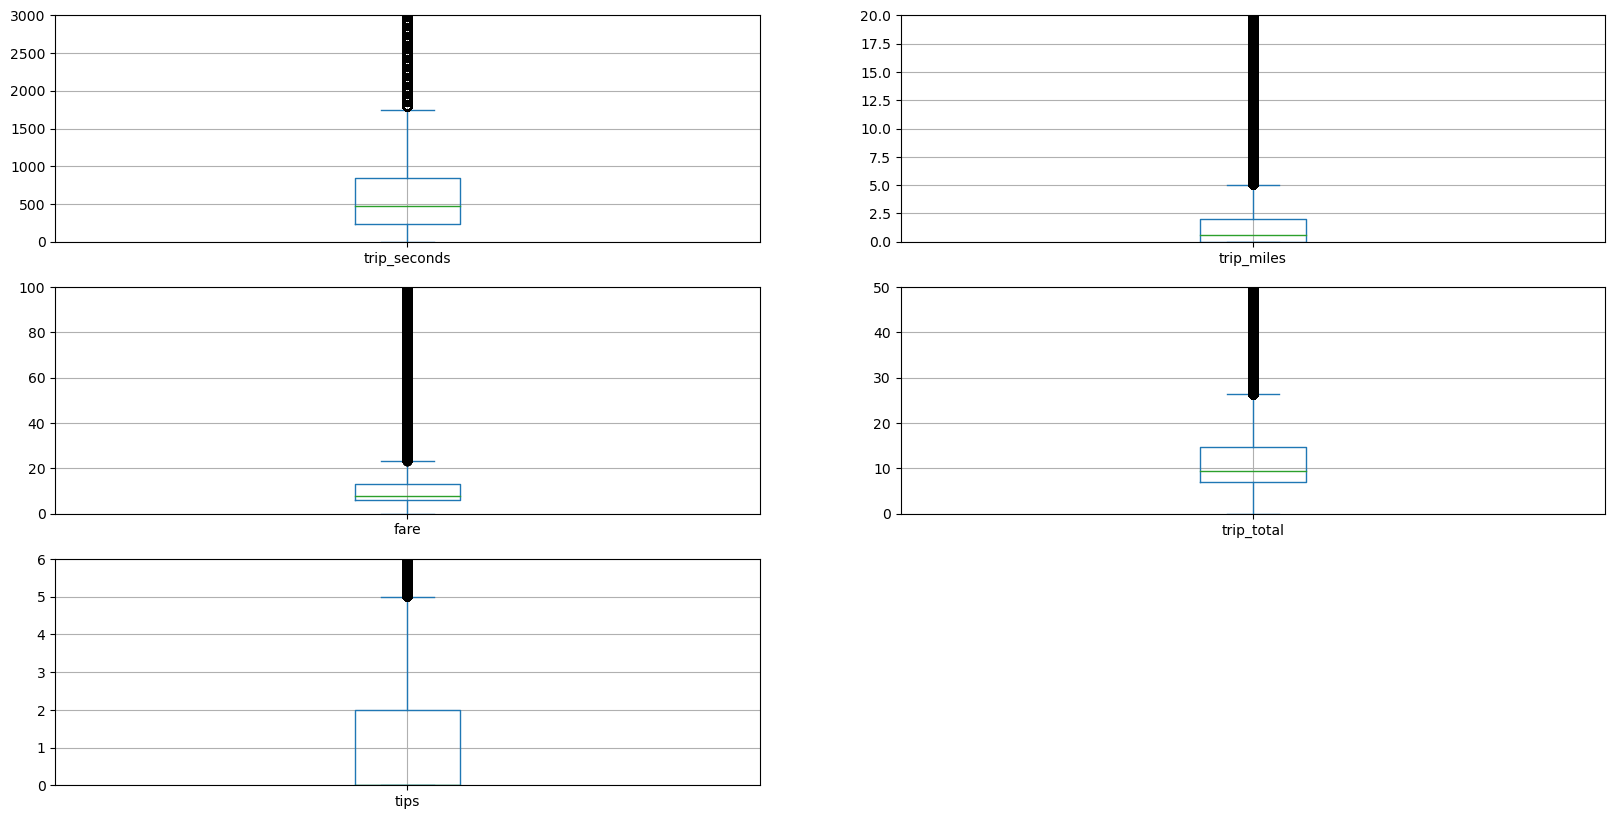

In [18]:
ax = df[['trip_seconds','trip_miles','fare','trip_total','tips']]\
        .plot(kind='box', subplots=True, layout=(3,2), grid=True, figsize=(20,10))

ax['trip_seconds'].set_ylim(0,3000)
ax['trip_miles'].set_ylim(0, 20)
ax['fare'].set_ylim(0, 100)
ax['trip_total'].set_ylim(0, 50)
ax['tips'].set_ylim(0,6);

В `trip_seconds` и `trip_miles` есть поездки, с длительностью и дальностью 0. Дальность 0 может быть в том случае, если такси было отменено, или поездка не состоялась по другим причинам, но время ожидания было засчитано, и за него могли списать оплату, такие строки мы не будем удалять.

В случае с нулевой длительностью поездок нам неизвестно, почему так могло получиться - может, они были отменены сразу после оформления, или была какая-то ошибка в данных - выяснить мы это не можем, но таких строк очень много, и они будут влиять на результаты исследования, следоательно их мы удалим.

Попробуем проверить, сможем ли мы заменить пропуски в `trip_seconds`:

In [19]:
df.query('trip_seconds == 0 and trip_start_timestamp != trip_end_timestamp')

Empty DataFrame
Columns: [trip_start_timestamp, trip_end_timestamp, trip_seconds, trip_miles, pickup_community_area, dropoff_community_area, fare, tips, tolls, extras, trip_total, payment_type, company, pickup_centroid_latitude, pickup_centroid_longitude, dropoff_centroid_latitude, dropoff_centroid_longitude, taxi_id]
Index: []

Удалим все выбивающиеся значения и сохраним в новую переменную. Построим боксплоты еще раз.

In [20]:
df_new = df[(df.trip_seconds != 0) & (df.trip_seconds < 1800) & (df.trip_miles < 5) & (df.fare < 22)\
            & (df.trip_total < 28) & (df.tips < 5)].reset_index(drop=True)

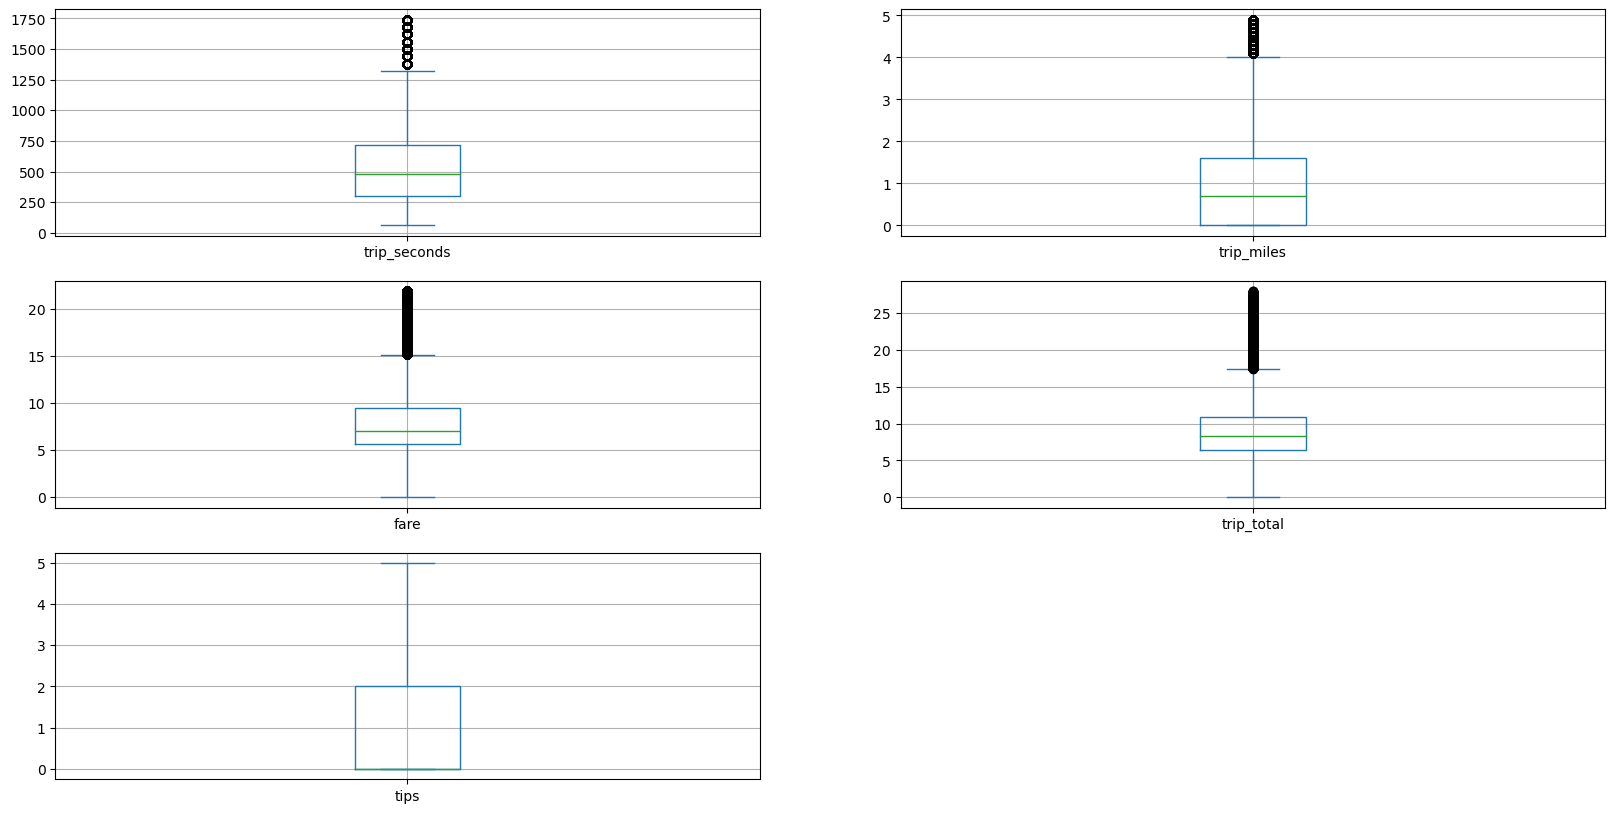

In [21]:
df_new[['trip_seconds','trip_miles','fare','trip_total', 'tips']]\
        .plot(kind='box', subplots=True, layout=(3,2), grid=True, figsize=(20,10));

Построим гистограммы по этим столбцам, чтобы нагляднее показать распределение значений.

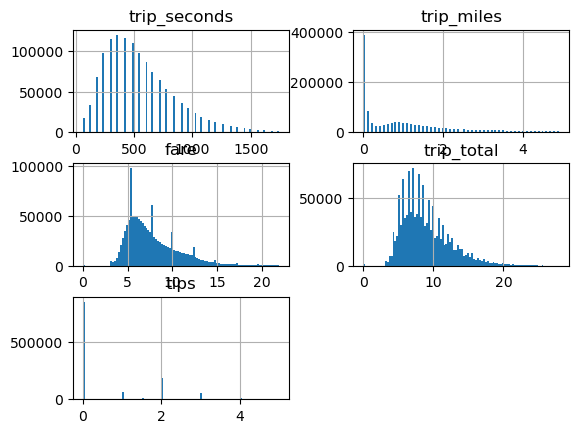

In [22]:
df_new[['trip_seconds','trip_miles','fare','trip_total','tips']].hist(bins=100);

Выведем информацию о таблице еще раз

In [23]:
display(df_new[['trip_seconds','trip_miles','fare','tips','trip_total']].describe().T)

count        mean         std   min     25%     50%     75%  \
trip_seconds  1281216.0  545.705829  301.389291  60.0  300.00  480.00  720.00   
trip_miles    1281216.0    1.030056    1.194319   0.0    0.00    0.70    1.60   
fare          1281216.0    7.835136    3.047474   0.0    5.65    7.05    9.45   
tips          1281216.0    0.715517    1.106006   0.0    0.00    0.00    2.00   
trip_total    1281216.0    8.981010    3.479738   0.0    6.45    8.25   10.85   

                  max  
trip_seconds  1740.00  
trip_miles       4.90  
fare            21.85  
tips             4.99  
trip_total      27.95

Минимальное время поездки теперь начинается с 60 секунд, и другие показатели сгладились.

Округлим столбец с датой начала поездки до часа:

In [24]:
df_new['hour_trip_start'] = df_new['trip_start_timestamp'].dt.floor('1H')

Присоединим `df_cover`  к нашему датафрейму по этому столбцу и проверим как теперь выглядит таблица:

In [25]:
df_new = df_new.merge(df_cover, on='hour_trip_start', how='left')
df_new.head()

trip_start_timestamp  trip_end_timestamp  trip_seconds  trip_miles  \
0  2015-02-06 06:45:00 2015-02-06 07:00:00         540.0         2.8   
1  2015-02-13 20:30:00 2015-02-13 20:45:00         600.0         2.0   
2  2015-03-11 23:30:00 2015-03-11 23:45:00         540.0         0.1   
3  2015-03-13 22:15:00 2015-03-13 22:15:00         360.0         1.7   
4  2015-02-08 03:15:00 2015-02-08 03:30:00         540.0         2.6   

   pickup_community_area  dropoff_community_area  fare  tips  tolls  extras  \
0                   21.0                    15.0  8.85   0.0    0.0     0.0   
1                    8.0                    28.0  8.25   1.0    0.0     0.0   
2                   28.0                     8.0  7.65   0.0    0.0     0.0   
3                   33.0                    32.0  6.65   0.0    0.0     1.0   
4                    8.0                     8.0  9.05   0.0    0.0     1.5   

   trip_total payment_type                    company  \
0        8.85    No Charge        Top Cab Affiliation   
1        9.25  Credit Card      KOAM Taxi Association   
2        7.65         Cash  Taxi Affiliation Services   
3        7.65  Credit Card    Choice Taxi Association   
4       10.55         Cash  Taxi Affiliation Services   

   pickup_centroid_latitude  pickup_centroid_longitude  \
0                 41.938666                 -87.711211   
1                 41.890922                 -87.618868   
2                 41.879255                 -87.642649   
3                 41.849247                 -87.624135   
4                 41.892042                 -87.631864   

   dropoff_centroid_latitude  dropoff_centroid_longitude  taxi_id  \
0                  41.954028                  -87.763399      250   
1                  41.879067                  -87.657005     1915   
2                  41.892508                  -87.626215      110   
3                  41.871016                  -87.631407     1802   
4                  41.904935                  -87.649907     1953   

      hour_trip_start  estimated_coverage  
0 2015-02-06 06:00:00                0.75  
1 2015-02-13 20:00:00                0.73  
2 2015-03-11 23:00:00                0.78  
3 2015-03-13 22:00:00                0.75  
4 2015-02-08 03:00:00                0.71

Создадим столбцы с днями недели и номером часа

In [26]:
df_new['trip_start_day'] = df_new['trip_start_timestamp'].dt.day_name(locale='Russian')
df_new['trip_number_day'] = df_new['trip_start_timestamp'].dt.weekday
df_new['trip_start_hr'] = pd.DatetimeIndex(df_new['trip_start_timestamp']).hour

### Рассчет необходимых показателей для каждого часа и дня недели<a id="time"></a>

создадим сводную таблицу по часам для построения графиков по ней

In [27]:
pivot = df_new.groupby(['trip_start_hr']).agg(taxi_id=('taxi_id','nunique'),
                                                                       trip_count=('taxi_id', 'count'),
                                                                       dur_mean=('trip_seconds', 'mean'),
                                                                       len_mean=('trip_miles', 'median'),
                                                                       total_sum=('trip_total', 'sum'),
                                                                       fare_sum=('fare', 'sum'),
                                                                       fare_mean=('fare', 'mean'),
                                                                       tips_sum=('tips', 'sum'),
                                                                       tips_mean=('tips', 'mean')).reset_index()
pivot['driver_pay'] = (pivot['fare_mean']*0.6) + pivot['tips_mean']
pivot

trip_start_hr  taxi_id  trip_count    dur_mean  len_mean  total_sum  \
0               0     2352       50469  522.019854       0.7  481614.89   
1               1     2238       40507  510.099983       0.7  386656.21   
2               2     2062       30893  490.637361       0.7  294154.95   
3               3     1935       27716  481.892048       0.7  262481.41   
4               4     1689       16863  474.371108       0.6  159193.57   
5               5     1568       11590  472.964625       0.5  108934.81   
6               6     1579        8389  470.802241       0.4   76322.46   
7               7     1928       17881  460.873553       0.5  151039.24   
8               8     2239       41975  506.903157       0.7  354141.51   
9               9     2433       63932  581.761246       0.7  555268.49   
10             10     2517       59901  559.291832       0.7  521701.55   
11             11     2557       53435  521.293160       0.7  460115.05   
12             12     2601       64807  509.629207       0.6  546952.07   
13             13     2625       63193  519.759151       0.6  537544.45   
14             14     2635       65876  520.104439       0.6  560229.59   
15             15     2650       63065  531.507809       0.6  541309.51   
16             16     2631       63783  544.404308       0.6  551575.85   
17             17     2644       67627  573.716119       0.7  591977.90   
18             18     2644       86027  655.721111       0.7  793446.16   
19             19     2633       97830  619.151181       0.7  907657.50   
20             20     2627       94500  562.378413       0.7  873225.76   
21             21     2581       71264  529.884935       0.7  658518.17   
22             22     2501       60888  524.204769       0.7  572544.25   
23             23     2443       58805  529.943712       0.7  560007.89   

     fare_sum  fare_mean  tips_sum  tips_mean  driver_pay  
0   411418.34   8.151902  37983.48   0.752610    5.643751  
1   329306.76   8.129626  30772.21   0.759676    5.637452  
2   248349.35   8.039017  24864.19   0.804849    5.628259  
3   221886.56   8.005721  21794.35   0.786345    5.589778  
4   136377.36   8.087372  12130.36   0.719348    5.571771  
5    95661.30   8.253779   7084.76   0.611282    5.563550  
6    70152.34   8.362420   4088.60   0.487376    5.504828  
7   139397.58   7.795849   9125.50   0.510346    5.187856  
8   319468.39   7.610921  28480.44   0.678510    5.245062  
9   495404.09   7.748922  48164.06   0.753364    5.402717  
10  466013.41   7.779727  42071.57   0.702352    5.370188  
11  408841.95   7.651201  34406.17   0.643888    5.234609  
12  481250.25   7.425899  42673.41   0.658469    5.114009  
13  471605.36   7.462937  41888.26   0.662862    5.140624  
14  490163.33   7.440697  43945.12   0.667088    5.131506  
15  475825.99   7.545009  40891.44   0.648401    5.175407  
16  485936.36   7.618587  41434.21   0.649612    5.220765  
17  521625.48   7.713273  45438.06   0.671892    5.299856  
18  695914.83   8.089493  64255.92   0.746927    5.600623  
19  788180.24   8.056631  74678.53   0.763350    5.597329  
20  753292.63   7.971351  72003.60   0.761943    5.544753  
21  565129.73   7.930087  55517.57   0.779041    5.537093  
22  489037.44   8.031754  48263.34   0.792658    5.611710  
23  478263.07   8.133034  44777.02   0.761449    5.641270

Построим графики по основным значениям

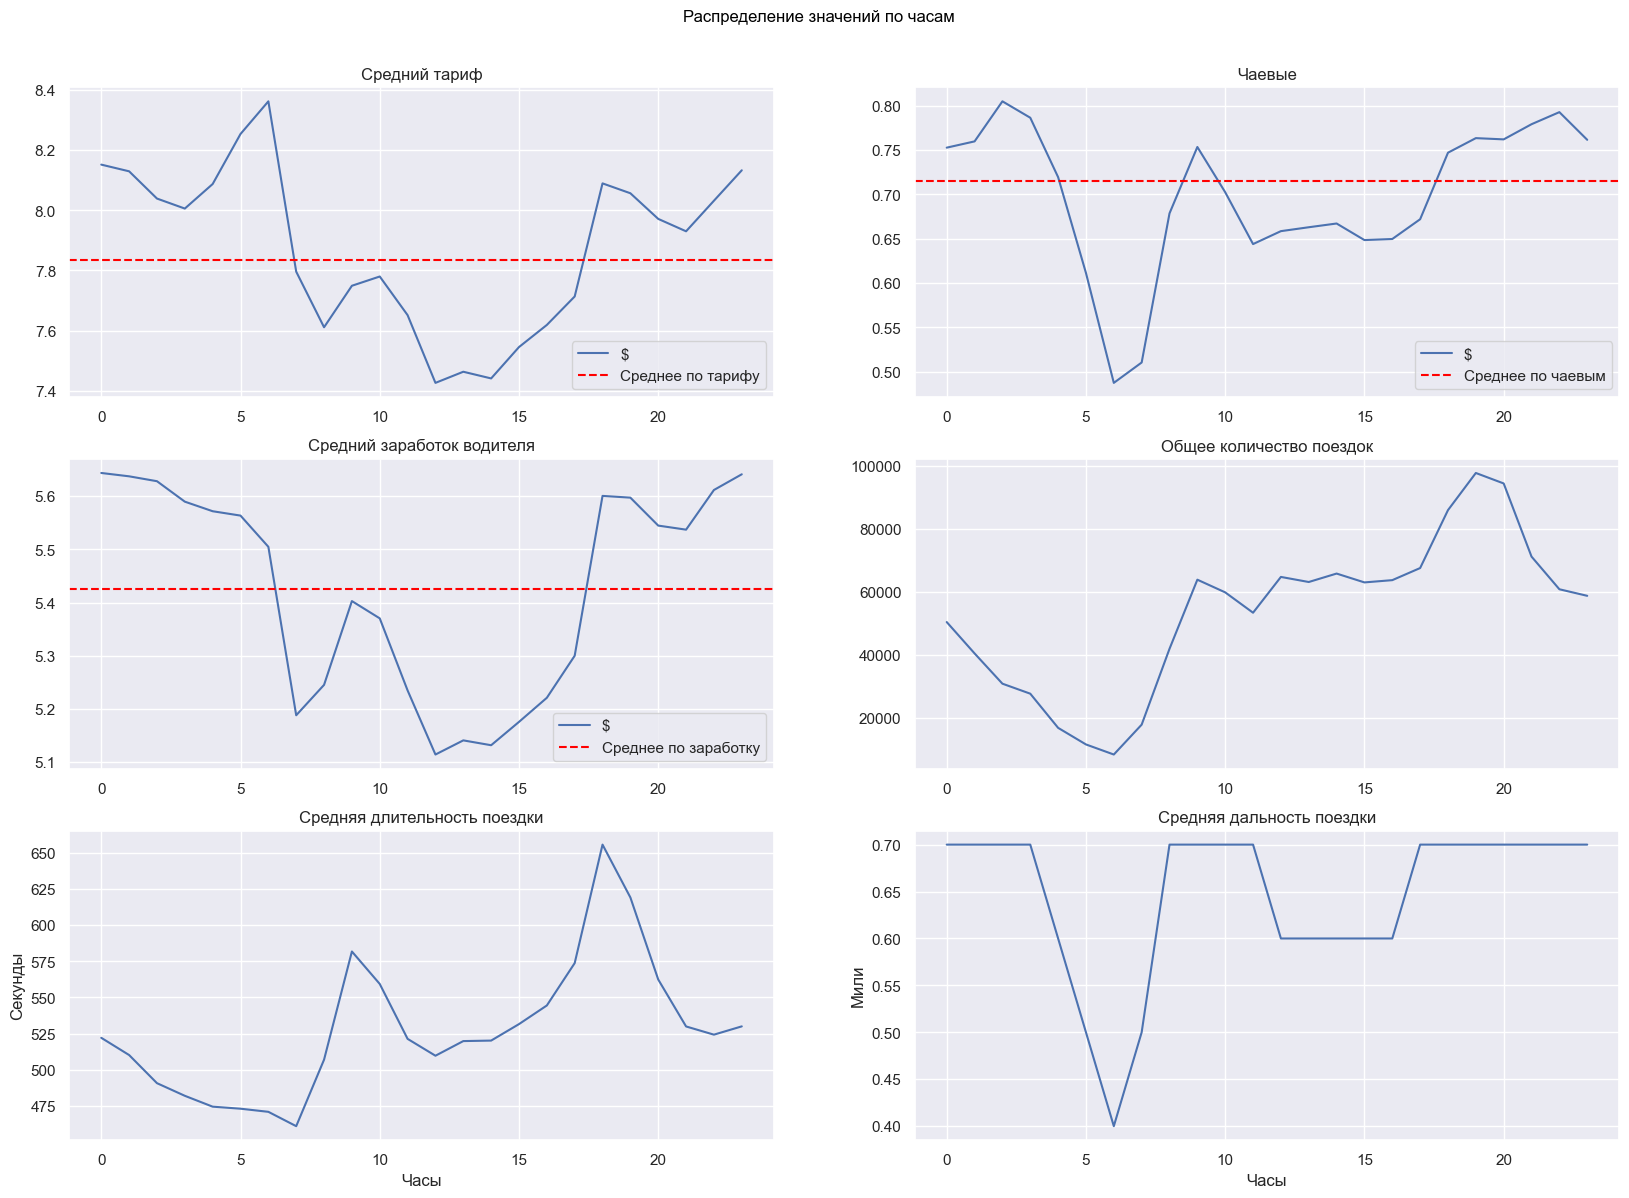

In [28]:
plt.rcParams ['figure.figsize'] = [20, 13]
plt.suptitle('Распределение значений по часам')
sns.set()
plt.subplots_adjust(top= 0.92 )

plt.subplot(3, 2, 1)
sns.lineplot(y='fare_mean', x='trip_start_hr', data=pivot)
plt.axhline(y=df_new['fare'].mean(), color='red', linestyle='--')
plt.title('Средний тариф')
plt.legend(title='', loc='lower right', labels=['$', 'Среднее по тарифу'])
plt.xlabel('')
plt.ylabel('')
plt.ylim()

plt.subplot(3, 2, 2)
sns.lineplot(y='tips_mean', x='trip_start_hr', data=pivot)
plt.axhline(y=df_new['tips'].mean(), color='red', linestyle='--')
plt.title('Чаевые')
plt.legend(title='', loc='lower right', labels=['$', 'Среднее по чаевым'])
plt.xlabel('')
plt.ylabel('')

plt.subplot(3, 2, 3)
sns.lineplot(y='driver_pay', x='trip_start_hr', data=pivot)
plt.axhline(y=pivot['driver_pay'].mean(), color='red', linestyle='--')
plt.title('Средний заработок водителя')
plt.legend(title='', loc='lower right', labels=['$', 'Среднее по заработку'])
plt.xlabel('')
plt.ylabel('')
plt.ylim()

plt.subplot(3, 2, 4)
sns.lineplot(y='trip_count', x='trip_start_hr', data=pivot)
plt.title('Общее количество поездок')
plt.xlabel('')
plt.ylabel('')
plt.ylim()

plt.subplot(3, 2, 5)
sns.lineplot(y='dur_mean', x='trip_start_hr', data=pivot)
plt.title('Средняя длительность поездки')
plt.xlabel('Часы')
plt.ylabel('Секунды')
plt.ylim()

plt.subplot(3, 2, 6)
sns.lineplot(y='len_mean', x='trip_start_hr', data=pivot)
plt.title('Средняя дальность поездки')
plt.xlabel('Часы')
plt.ylabel('Мили')
plt.ylim()

plt.show();

По графикам видно, что:
* с 16 до 7 часов стоимость тарифа превышает средние значения.
* Чаевые водителей выше среднего также в период с 16 до 7 часов, и небольшой пик в районе 9 утра.
* Общее количество поездок увеличивается ближе к вечеру и достигает максимальных значений к 20 часам.
* Заработок водителей с 6 до 17 часов выше среднего, и достигает пиковых значений вечером. 
* Средняя длительность поездки ниже всего рано утром, с 5 до 7 утра, и достигает пиковых значений с 7 до 10 и с 15 до 20 часов, вероятно, в этом виноваты пробки.
* Средняя дальность поездки выше всего с 16 до 3 утра, сравнивая с графиком длительности, становится ясно, что в это время пробок нет.

Теперь построим сводную таблицу и графики по дням недели

In [29]:
pivot_day = df_new.groupby(['trip_start_day','trip_number_day']).agg(taxi_id=('taxi_id','nunique'),
                                                                       trip_count=('taxi_id', 'count'),
                                                                       dur_mean=('trip_seconds', 'mean'),
                                                                       len_mean=('trip_miles', 'mean'),
                                                                       total_sum=('trip_total', 'sum'),
                                                                       fare_sum=('fare', 'sum'),
                                                                       fare_mean=('fare', 'mean'),
                                                                       tips_sum=('tips', 'sum'),
                                                                       tips_mean=('tips', 'mean')).sort_values('trip_number_day').reset_index()
pivot_day['driver_pay'] = (pivot_day['fare_mean']*0.6) + pivot_day['tips_mean']
pivot_day

trip_start_day  trip_number_day  taxi_id  trip_count    dur_mean  len_mean  \
0    Понедельник                0     2792      127825  519.620419  0.959822   
1        Вторник                1     2786      134046  530.389419  0.955297   
2          Среда                2     2813      153107  533.397559  0.939035   
3        Четверг                3     2807      195914  534.822728  0.970843   
4        Пятница                4     2871      229932  560.639580  1.025129   
5        Суббота                5     2828      255170  585.278990  1.147701   
6    Воскресенье                6     2795      185222  523.421624  1.114540   

    total_sum    fare_sum  fare_mean   tips_sum  tips_mean  driver_pay  
0  1097287.49   975644.97   7.632662   86069.29   0.673337    5.252934  
1  1157491.32  1020039.68   7.609624  100480.05   0.749594    5.315368  
2  1318875.76  1161942.91   7.589091  115589.36   0.754958    5.308412  
3  1704790.22  1499362.13   7.653165  148161.73   0.756259    5.348158  
4  2054432.03  1798325.91   7.821121  163612.01   0.711567    5.404239  
5  2447935.59  2098124.60   8.222458  176886.75   0.693211    5.626686  
6  1725800.83  1485061.94   8.017741  125932.98   0.679903    5.490547

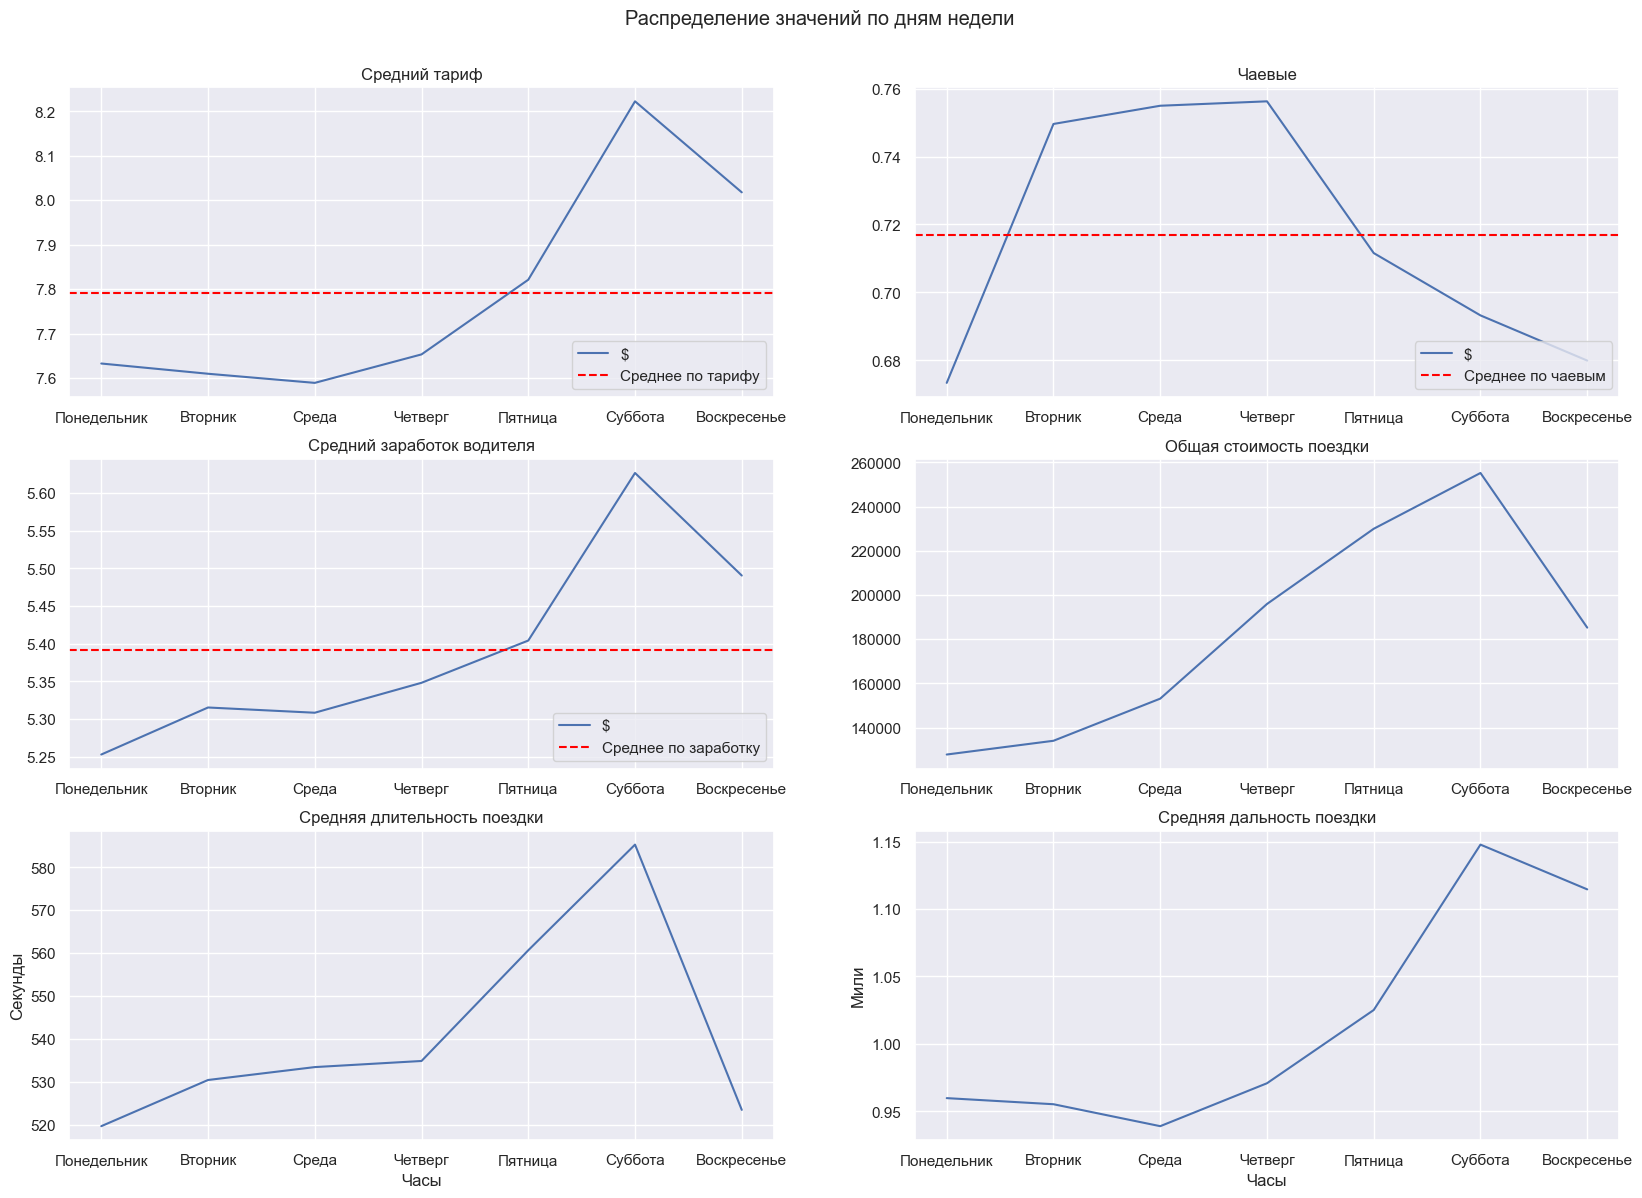

In [30]:
plt.rcParams ['figure.figsize'] = [20, 13]
plt.suptitle('Распределение значений по дням недели')
sns.set()
plt.subplots_adjust(top= 0.92 )

plt.subplot(3, 2, 1)
sns.lineplot(y='fare_mean', x='trip_start_day', data=pivot_day)
plt.axhline(y=pivot_day['fare_mean'].mean(), color='red', linestyle='--')
plt.title('Средний тариф')
plt.legend(title='', loc='lower right', labels=['$', 'Среднее по тарифу'])
plt.xlabel('')
plt.ylabel('')
plt.ylim()

plt.subplot(3, 2, 2)
sns.lineplot(y='tips_mean', x='trip_start_day', data=pivot_day)
plt.axhline(y=pivot_day['tips_mean'].mean(), color='red', linestyle='--')
plt.title('Чаевые')
plt.legend(title='', loc='lower right', labels=['$', 'Среднее по чаевым'])
plt.xlabel('')
plt.ylabel('')

plt.subplot(3, 2, 3)
sns.lineplot(y='driver_pay', x='trip_start_day', data=pivot_day)
plt.title('Средний заработок водителя')
plt.axhline(y=pivot_day['driver_pay'].mean(), color='red', linestyle='--')
plt.legend(title='', loc='lower right', labels=['$', 'Среднее по заработку'])
plt.xlabel('')
plt.ylabel('')
plt.ylim()

plt.subplot(3, 2, 4)
sns.lineplot(y='trip_count', x='trip_start_day', data=pivot_day)
plt.title('Общая стоимость поездки')
plt.xlabel('')
plt.ylabel('')
plt.ylim()

plt.subplot(3, 2, 5)
sns.lineplot(y='dur_mean', x='trip_start_day', data=pivot_day)
plt.title('Средняя длительность поездки')
plt.xlabel('Часы')
plt.ylabel('Секунды')
plt.ylim()

plt.subplot(3, 2, 6)
sns.lineplot(y='len_mean', x='trip_start_day', data=pivot_day)
plt.title('Средняя дальность поездки')
plt.xlabel('Часы')
plt.ylabel('Мили')
plt.ylim()

plt.show();

По графикам распределения значений по дням недели видно, что почти на всех графиках показатели достигают пиковых значений к концу недели, с пятницы до воскресенья. Только график чаевых водителей показывает, что большую часть чаевых они зарабатывают в будни, но общий заработок выше с четверга по воскресенье.

Построим тепловую карту распределения оплаты водителей по дням недели и часам.

In [31]:
drivers = df_new.groupby(['trip_start_day','trip_number_day','trip_start_hr']).agg(taxi_id=('taxi_id','nunique'),
                                                                       fare_mean=('fare', 'mean'),
                                                                       tips_mean=('tips', 'mean'))\
                                                                       .sort_values('trip_number_day').reset_index()
drivers['driver_pay'] = ((drivers['fare_mean']*0.6) + drivers['tips_mean'])

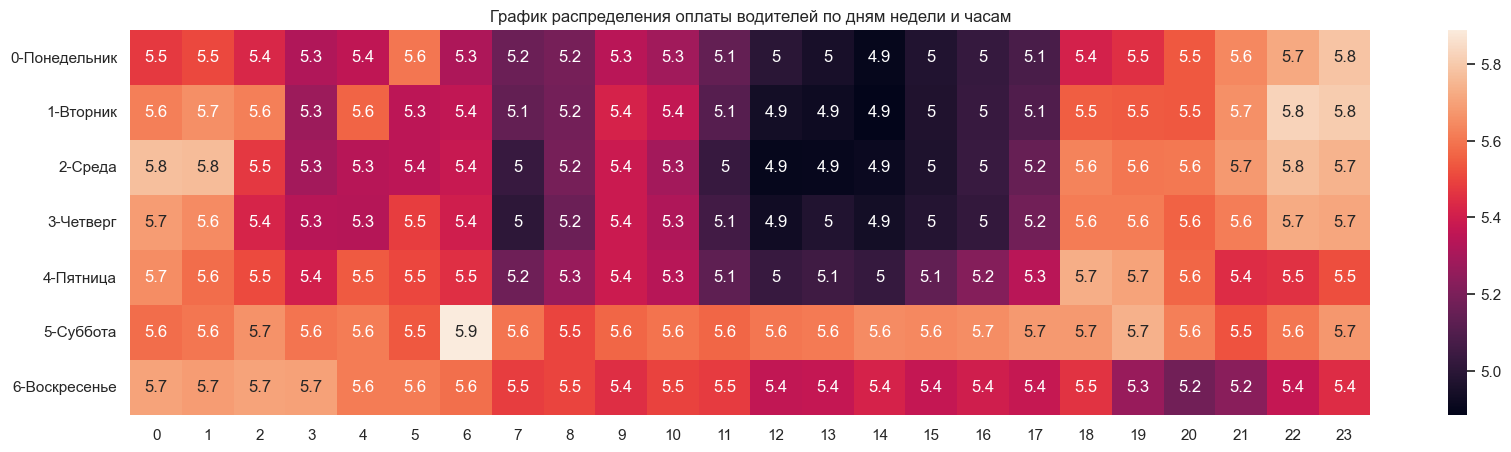

In [32]:
plt.figure(figsize=(20, 5))
ax= sns.heatmap(pd.pivot_table(data=drivers, index=['trip_number_day','trip_start_day'],\
                               columns='trip_start_hr', values='driver_pay', aggfunc='mean')\
                               .sort_values('trip_number_day'), annot=True)
ax.set(xlabel='', ylabel='')
ax.set(title='График распределения оплаты водителей по дням недели и часам');

Здесь нагляднее видно, что равномерное распределение большей части дохода водителей происходит в общепринятые рабочие часы в будни, и наивысшую оплату они получают в вечерние часы пятницы, субботы, и утренние часы воскресенья.

### Критические периоды дефицита предложения и визуализации<a id="analysis"></a>

Построим тепловую карту коэффициента покрытия по дням недели и часам

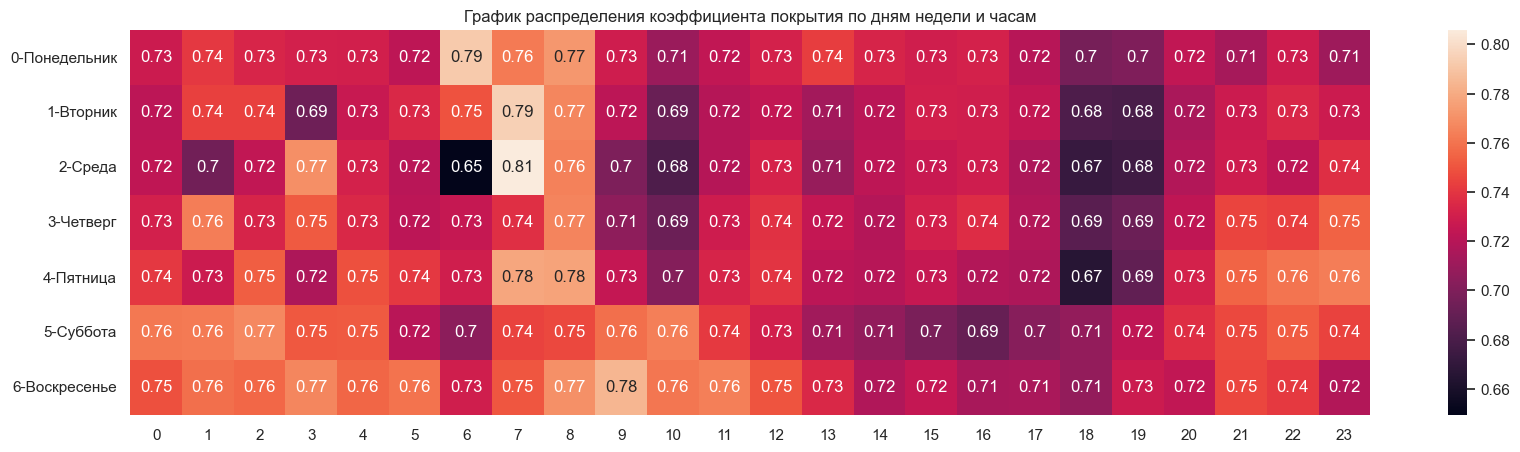

In [33]:
plt.figure(figsize=(20, 5))
ax= sns.heatmap(pd.pivot_table(data=df_new, index=['trip_number_day','trip_start_day'],\
                               columns='trip_start_hr', values='estimated_coverage')\
                               .sort_values('trip_number_day'), annot=True)
ax.set(xlabel='', ylabel='')
ax.set(title='График распределения коэффициента покрытия по дням недели и часам');

Видно, что самый высокий спрос на такси в будние дни, в 9-10 часов утра и 17-19 часов вечера, когда большинство людей едет на работу/с работы. Также есть момент пониженного спроса в среду в 5 утра. Как мы видели по графикам выше, в утренние часы в общем меньше и поездок и количества машин, но почему коэффициент упал именно в среду - можно только предположить, что в этот день бОльшая часть водителей обычно берет выходной.

Рассчитаем оптимальное число машин на линии для обеспечения наибольшего показателя покрытия.

In [34]:
taxi = df_new.groupby(['trip_number_day','trip_start_day','trip_start_hr'])[['taxi_id']].nunique().reset_index()
taxi['estimated_coverage'] = df_new['estimated_coverage']
taxi['super_cover'] = taxi['taxi_id'] / taxi['estimated_coverage']
taxi['taxi_goal'] = taxi['super_cover'] - taxi['taxi_id']

Выведем таблицу, показывающую, сколько машин должно быть на линии в определенный день и час для достижения наибольшего покрытия.

In [35]:
pd.set_option('display.max_columns', None)
taxi_pivot = taxi.pivot_table(index=['trip_number_day','trip_start_day'], columns='trip_start_hr', values='super_cover')
(taxi_pivot.T.style
 .format("{:_.0f}")
 .hide(names=True))

Также рассчитаем объем недополученной выручки, возникшей из-за дефицита предложения

In [36]:
cash = df_new.groupby(['trip_number_day','trip_start_day','trip_start_hr'])[['trip_total']].sum().reset_index()
cash['estimated_coverage'] = df_new['estimated_coverage']
cash['total_max'] = cash['trip_total'] / cash['estimated_coverage']
cash['total_lost'] = cash['total_max'] - cash['trip_total']

Выведем таблицу с потерянной выручкой и подсветим наибольшие суммы

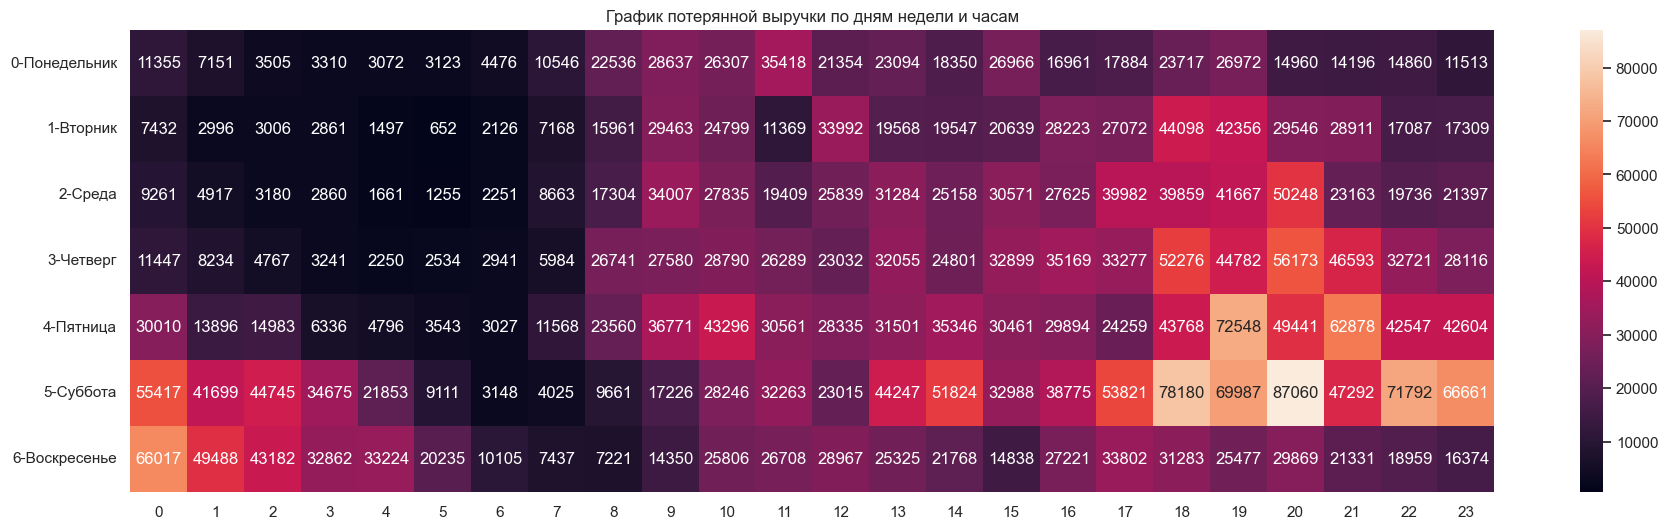

In [37]:
plt.figure(figsize=(22, 6))
ax = sns.heatmap(pd.pivot_table(data=cash,index=['trip_number_day','trip_start_day'],
                                columns='trip_start_hr', values='total_lost')
                 .sort_values('trip_number_day'),annot=True,fmt=".0f")
ax.set(xlabel='', ylabel='')
ax.set(title='График потерянной выручки по дням недели и часам');

Видно, что наибольшие потери выручки происходят с 18 до 23 часов в четверг-пятницу и c 18 до 3 утра в субботу и воскресенье

Выведем таблицу, показывающую, сколько машин в какой день недели нужно добавить для нормального покрытия.

In [38]:
pd.set_option('display.max_columns', None)
taxi_pivot = taxi.pivot_table(index=['trip_number_day','trip_start_day'], columns='trip_start_hr', values='taxi_goal')
(taxi_pivot.T.style
 .format("{:_.0f}")
 .hide(names=True))

Выведем наглядные графики, построенные по дням недели и часам, показывающие, сколько было заработано, сколько выручки потеряно, и сколько можно было заработать.

In [39]:
cashday = cash.groupby(['trip_number_day','trip_start_day'])[['trip_total','total_lost','total_max']].sum().reset_index()
newnames = {'trip_total': 'полученная', 'total_lost': 'потерянная', 'total_max': 'возможная'}

fig = px.bar(cashday, x=['trip_total','total_lost','total_max'], y='trip_start_day',text_auto=True, orientation= 'h')
fig.update_layout(title='График фактической, потерянной и прогнозируемой выручки по дням недели',
                   xaxis_title='',
                   yaxis_title='',
                   legend=dict(x=0.86, y=1),
                   legend_title='Выручка',
                   yaxis=dict(autorange='reversed'),
                   width=1000,
                   height=500
                 )
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.show()

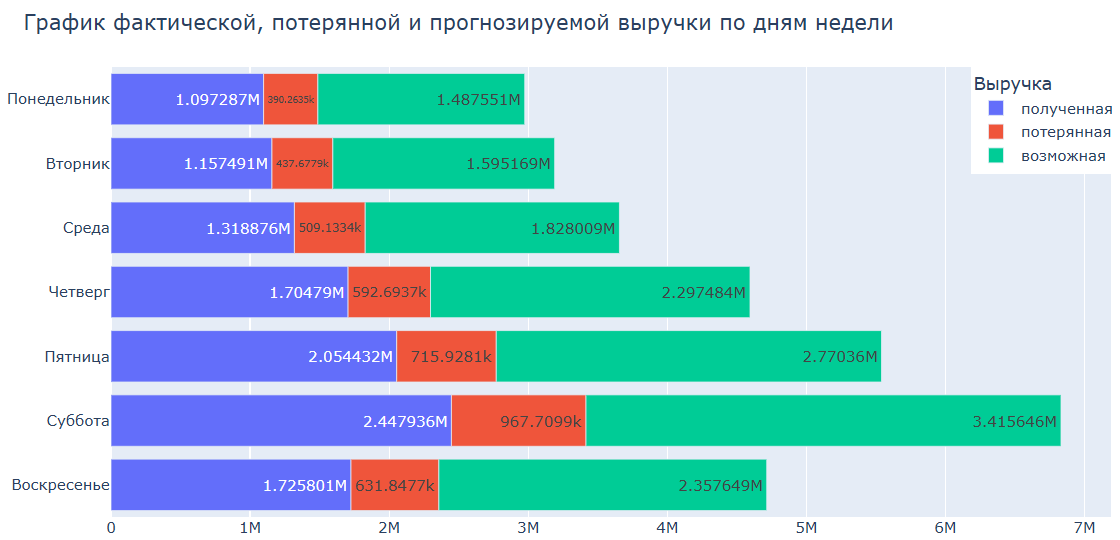

In [40]:
Image(filename='newplot (9).png')

Основной пласт потерянной выручки приходится на пятницу, субботу и воскресенье.

In [41]:
cashhour = cash.groupby(['trip_start_hr'])[['trip_total','total_lost','total_max']].sum().reset_index()
fig = px.bar(cashhour, x=['trip_total','total_lost','total_max'], y='trip_start_hr', orientation = 'h', text_auto=True)
fig.update_layout(title='График фактической, потерянной и прогнозируемой выручки по часам',
                   xaxis_title='',
                   yaxis_title='',
                   legend=dict(x=0.86, y=1),
                   legend_title='Выручка',
                   yaxis=dict(autorange='reversed'),
                   width=1000,
                   height=700
                 )
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.show()

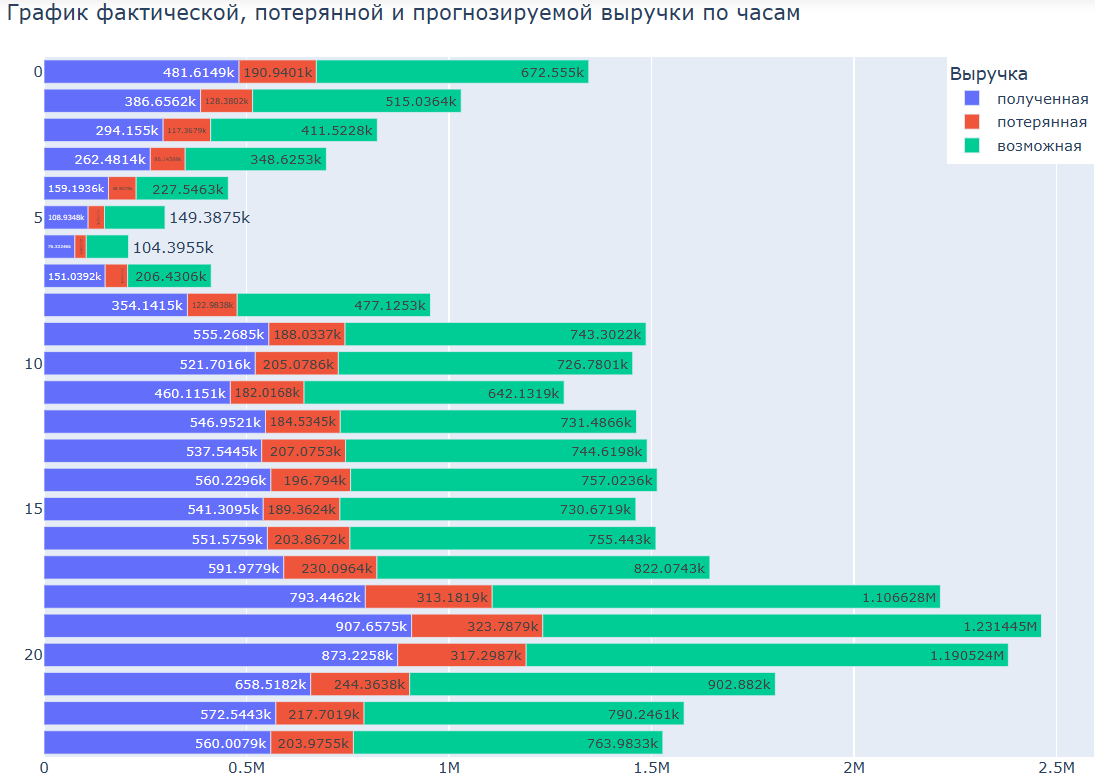

In [42]:
Image(filename='newplot (8).png')

Наибольшие суммы потерянной выручки приходятся на время между 18 и 21 часами. Также показатели равномерно распределяются с 9 до 18 часов дня. Наименьшие значения приходятся на 5-7 часов утра.

### Выводы<a id="end"></a>

Стоимость тарифа превышает средние значения с 16 до 5 часов. Чаевые водителей выше среднего также в этот период.
Заработок водителей с 10 до 0 часов выше среднего, и достигает пиковых значений вечером. Также размер заработка водителей зависит от количества поездок.
Средняя длительность поездки ниже всего рано утром из-за отсутствия пробок, и достигает пиковых значений с 7 до 10 и с 15 до 20 часов. Также средняя дальность поездки выше всего с 20 до 5 утра. В это время пробок нет, и стоимость тарифа ниже - пассажирам выгоднее ездить на дальние расстояния.
Почти на всех графиках распределения значений по дням недели видно показатели достигают пиковых значений к концу недели, с пятницы до воскресенья. Только график чаевых водителей показывает, что большую часть чаевых они зарабатывают в будни - вероятно, из-за вечерних поездок, когда люди едут с работы, но общий заработок выше с четверга по воскресенье.

Равномерное распределение дохода водителей происходит в общепринятые рабочие часы в будни, и наивысшую оплату они получают в вечерние часы пятницы, субботы, и утренние часы воскресенья.

Мы выяснили, сколько машин нужно добавить в каждый период времени по дням недели и часам, чтобы покрытие было наибольшим. Исходя из всех построенных графиков, можно прийти к выводу, что дополнительное количество машин нужно добавлять в вечерние часы будних дней - с 17 до 20, а так же в ночь на субботу и воскресенье. Но, чтобы сохранить имеющуюся тарифную ставку и спрос на такси, есть предложение добавить не указанное количество машин, а к примеру 50% от этих цифр.

### Презентация<a id="presentation"></a>

<https://github.com/OrlovaD/Portfolio_Projects/blob/main/taxi/taxi_preza.pdf>